# **사전 학습된 모델을 활용한 전이학습 (Transfer Learning with Pretrained Network)**

## 1. 라이브러리 불러오기

In [ ]:
!pip3 install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from os import makedirs, listdir
from os.path import join

import random

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from torchmetrics import Accuracy
from torchsummary import summary
from tqdm import tqdm

## 2. 시드 고정

In [ ]:
def fix_seed(seed) :
  # Fix Seed
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 3. 손실 함수 및 평가 지표 평균화

In [ ]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum/self.count

## 3. 시험 데이터셋 다운로드

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

--2025-07-08 05:23:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  29.7MB/s    in 2.2s    

2025-07-08 05:23:08 (29.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## 4. Custom Dataloader 생성

In [ ]:
########## Custom DataLoader ##########
class PyTorchCustomDataset(Dataset):
  def __init__(self, root_dir="cats_and_dogs_filtered/train", transform=None):
    self.image_abs_path = root_dir
    self.transform = transform
    self.label_list = listdir(self.image_abs_path)
    self.label_list.sort()
    self.x_list = []
    self.y_list = []
    for label_index, label_str in enumerate(self.label_list):
      img_path = join(self.image_abs_path, label_str)
      img_list = listdir(img_path)
      for img in img_list:
        self.x_list.append(join(img_path, img))
        self.y_list.append(label_index)
  def __len__(self):
    return len(self.x_list)

  def __getitem__(self, idx):
    image = Image.open(self.x_list[idx])
    if image.mode != "RGB":
      image = image.convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
    return image, torch.tensor(self.y_list[idx]).type(torch.LongTensor)

  def __save_label_map__(self, dst_text_path="label_map.txt"):
    label_list = self.label_list
    f = open(dst_text_path, 'w')
    for i in range(len(label_list)):
      f.write(label_list[i]+'\n')
    f.close()
    pass

  def __num_classes__(self):
    return len(self.label_list)

## Pretrained Model Parameter 전체를 학습 (Unfrozen Backbone)

In [ ]:
########## Training Code ##########
def transfer_learning_unfrozen(model, img_channels=3, img_size=224, num_classes=2, lr=1e-4, total_epochs=20, seed=42, batch_size=16, src="cats_and_dogs_filtered") :
    # Load Dataset
    train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                                                                         saturation=0.2, hue=0.1)], p=0.8),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량
    test_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량

    # Create Custom Dataset Instance
    train_dataset = PyTorchCustomDataset(join(src, "train"), train_transform)
    test_dataset = PyTorchCustomDataset(join(src, "validation"), test_transform)

    # Fix Seed
    fix_seed(seed)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Check Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Current Device : {device}")

    # Fix Seed
    fix_seed(seed)

    # Unfreeze CNN Backbone
    for param in model.parameters() :
      param.requires_grad = True

    # Replace Linear Layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes) # Customize Classifier

    # Assign Device
    model = model.to(device)

    # Summarize Model
    summary(model, (img_channels, img_size, img_size))

    # Create Optimizer Instance
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Create Loss Instance
    criterion = nn.CrossEntropyLoss()

    # Create Metric Instance
    metric = Accuracy("multiclass", num_classes=num_classes).to(device)

    # Create AverageMeter Instance
    train_loss, train_acc = AverageMeter(), AverageMeter()
    test_loss, test_acc = AverageMeter(), AverageMeter()

    # Create List Instance
    train_loss_list, train_acc_list = [], []
    test_loss_list, test_acc_list = [], []

    # Create Directory
    ckpt_dir, graph_dir = "ckpt/backbone_unfrozen", "result/backbone_unfrozen"
    makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

    # Set Best Accuracy
    best_acc = 0

    # Start Training
    for epoch in range(total_epochs) :
      # Create TQDM Bar Instance
      train_bar = tqdm(train_loader)

      # Reset AverageMeter
      train_loss.reset(), train_acc.reset()

      # Set Training Mode
      model.train()

      # Training Phase
      for data in train_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        # Update Classifier Weights
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

        # Show Training Status
        train_bar.set_description(desc=f"[Train] [{epoch+1}/{total_epochs}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

      # Add Training Loss and Accuracy
      train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

      # Create TQDM Bar Instance
      test_bar = tqdm(test_loader)

      # Reset AverageMeter
      test_loss.reset(), test_acc.reset()

      # Evaluate Model
      with torch.no_grad() :
        # Set Test Mode
        model.eval()

        for data in test_bar :
          img, label = data
          img, label = img.to(device), label.to(device)

          # Update Classifier Weights
          pred = model(img)
          loss = criterion(pred, label)

          # Compute Metric
          acc = metric(pred, label)

          # Update AverageMeter
          test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

          # Show Training Status
          test_bar.set_description(desc=f"[Test] [{epoch+1}/{total_epochs}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

      # Add Test Loss and Accuracy
      test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

      # Save Network
      if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
      torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

      # Plot Training vs. Test Loss Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
      plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
      plt.title("Loss (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Loss")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/loss.png")

      # Plot Training vs. Test Accuracy Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
      plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
      plt.title("Accuracy (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Accuracy")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/accuracy.png")

### 훈련 진행

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Current Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU

[Train] [1/20] < Loss:0.5910 | Acc.:0.7005 >: 100%|██████████| 125/125 [00:15<00:00,  7.86it/s]
[Test] [1/20] < Loss:0.5205 | Acc.:0.8026 >: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s]
[Train] [2/20] < Loss:0.5065 | Acc.:0.8250 >: 100%|██████████| 125/125 [00:15<00:00,  8.06it/s]
[Test] [2/20] < Loss:0.4460 | Acc.:0.8710 >: 100%|██████████| 63/63 [00:03<00:00, 16.83it/s]
[Train] [3/20] < Loss:0.4372 | Acc.:0.8780 >: 100%|██████████| 125/125 [00:16<00:00,  7.42it/s]
[Test] [3/20] < Loss:0.3893 | Acc.:0.9028 >: 100%|██████████| 63/63 [00:03<00:00, 17.37it/s]
[Train] [4/20] < Loss:0.3974 | Acc.:0.8905 >: 100%|██████████| 125/125 [00:15<00:00,  8.00it/s]
[Test] [4/20] < Loss:0.3454 | Acc.:0.9286 >: 100%|██████████| 63/63 [00:03<00:00, 17.49it/s]
[Train] [5/20] < Loss:0.3575 | Acc.:0.9155 >: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]
[Test] [5/20] < Loss:0.3115 | Acc.:0.9395 >: 100%|██████████| 63/63 [00:03<00:00, 17.68it/s]
[Train] [6/20] < Loss:0.3276 | Acc.:0.9205 >: 100%|████

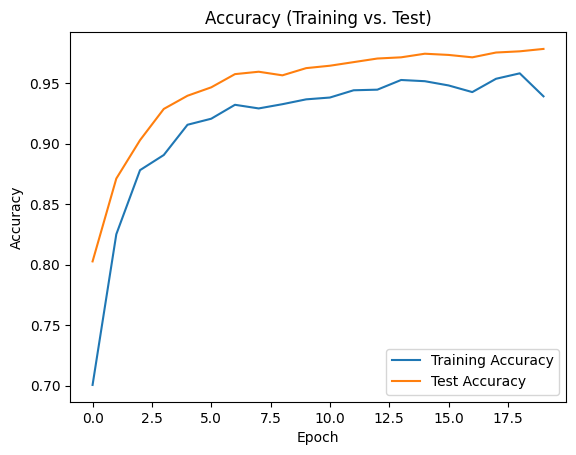

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
transfer_learning_unfrozen(model)

## Pretrained Model Parameter 일부만 학습 (Frozen Backbone)

In [ ]:
########## Training Code ##########
def transfer_learning_frozen(model, img_channels=3, img_size=224, num_classes=2, lr=1e-2, total_epochs=10, seed=42, batch_size=16, src="cats_and_dogs_filtered") :
    # Load Dataset
    train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                                                                         saturation=0.2, hue=0.1)], p=0.8),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량
    test_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량

    # Create Custom Dataset Instance
    train_dataset = PyTorchCustomDataset(join(src, "train"), train_transform)
    test_dataset = PyTorchCustomDataset(join(src, "validation"), test_transform)

    # Fix Seed
    fix_seed(seed)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Check Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Current Device : {device}")

    # Fix Seed
    fix_seed(seed)

    # Freeze CNN Backbone
    for param in model.parameters() :
      param.requires_grad = False

    # Replace Linear Layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes) # Customize Classifier

    # Assign Device
    model = model.to(device)

    # Summarize Model
    summary(model, (img_channels, img_size, img_size))

    # Create Optimizer Instance
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Create Loss Instance
    criterion = nn.CrossEntropyLoss()

    # Create Metric Instance
    metric = Accuracy("multiclass", num_classes=num_classes).to(device)

    # Create AverageMeter Instance
    train_loss, train_acc = AverageMeter(), AverageMeter()
    test_loss, test_acc = AverageMeter(), AverageMeter()

    # Create List Instance
    train_loss_list, train_acc_list = [], []
    test_loss_list, test_acc_list = [], []

    # Create Directory
    ckpt_dir, graph_dir = "ckpt/backbone_frozen", "result/backbone_frozen"
    makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

    # Set Best Accuracy
    best_acc = 0

    # Start Training
    for epoch in range(total_epochs) :
      # Create TQDM Bar Instance
      train_bar = tqdm(train_loader)

      # Reset AverageMeter
      train_loss.reset(), train_acc.reset()

      # Set Training Mode
      model.train()

      # Training Phase
      for data in train_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        # Update Classifier Weights
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

        # Show Training Status
        train_bar.set_description(desc=f"[Train] [{epoch+1}/{total_epochs}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

      # Add Training Loss and Accuracy
      train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

      # Create TQDM Bar Instance
      test_bar = tqdm(test_loader)

      # Reset AverageMeter
      test_loss.reset(), test_acc.reset()

      # Evaluate Model
      with torch.no_grad() :
        # Set Test Mode
        model.eval()

        for data in test_bar :
          img, label = data
          img, label = img.to(device), label.to(device)

          # Update Classifier Weights
          pred = model(img)
          loss = criterion(pred, label)

          # Compute Metric
          acc = metric(pred, label)

          # Update AverageMeter
          test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

          # Show Training Status
          test_bar.set_description(desc=f"[Test] [{epoch+1}/{total_epochs}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

      # Add Test Loss and Accuracy
      test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

      # Save Network
      if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
      torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

      # Plot Training vs. Test Loss Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
      plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
      plt.title("Loss (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Loss")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/loss.png")

      # Plot Training vs. Test Accuracy Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
      plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
      plt.title("Accuracy (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Accuracy")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/accuracy.png")

### 훈련 진행

Current Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU

[Train] [1/10] < Loss:0.2599 | Acc.:0.8915 >: 100%|██████████| 125/125 [00:14<00:00,  8.64it/s]
[Test] [1/10] < Loss:0.0843 | Acc.:0.9792 >: 100%|██████████| 63/63 [00:03<00:00, 16.63it/s]
[Train] [2/10] < Loss:0.1647 | Acc.:0.9355 >: 100%|██████████| 125/125 [00:14<00:00,  8.62it/s]
[Test] [2/10] < Loss:0.0877 | Acc.:0.9603 >: 100%|██████████| 63/63 [00:04<00:00, 13.87it/s]
[Train] [3/10] < Loss:0.1368 | Acc.:0.9440 >: 100%|██████████| 125/125 [00:14<00:00,  8.61it/s]
[Test] [3/10] < Loss:0.0792 | Acc.:0.9742 >: 100%|██████████| 63/63 [00:03<00:00, 17.60it/s]
[Train] [4/10] < Loss:0.1472 | Acc.:0.9390 >: 100%|██████████| 125/125 [00:14<00:00,  8.83it/s]
[Test] [4/10] < Loss:0.0555 | Acc.:0.9841 >: 100%|██████████| 63/63 [00:03<00:00, 16.27it/s]
[Train] [5/10] < Loss:0.1246 | Acc.:0.9485 >: 100%|██████████| 125/125 [00:14<00:00,  8.45it/s]
[Test] [5/10] < Loss:0.0555 | Acc.:0.9851 >: 100%|██████████| 63/63 [00:03<00:00, 17.41it/s]
[Train] [6/10] < Loss:0.1204 | Acc.:0.9520 >: 100%|████

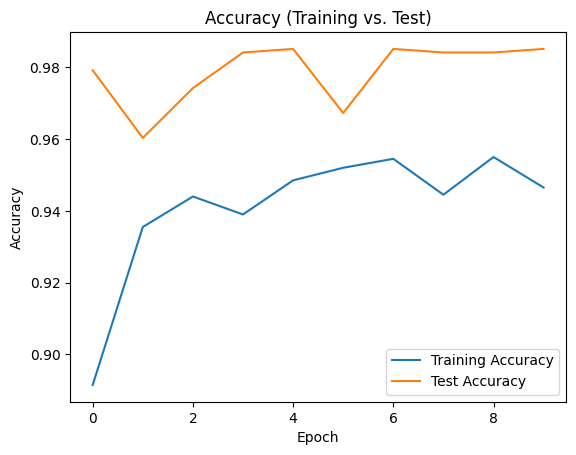

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
transfer_learning_frozen(model)